# CHAPTER 12 - Quantum Generative Adversarial Networks - PennyLane Code

In [1]:
import pennylane as qml
import numpy as np

import torch
import torch.nn as nn

seed = 1234
np.random.seed(seed)
torch.manual_seed(seed)

In [2]:
phi = np.pi / 3
theta = np.pi / 4
delta = np.pi / 5

In [3]:
def PrepareTrueState():
    qml.U3(theta, phi, delta, wires = 0)

In [4]:
def GeneratorVF(weights):
    qml.U3(weights[0], weights[1], weights[2], wires = 0)

def DiscriminatorVF(nqubits, weights, reps = 1):
    par = 0 # Index for parameters.
    for rep in range(reps):
        for q in range(nqubits):
            qml.RX(weights[par], wires = q)
            par += 1
            qml.RY(weights[par], wires = q)
            par += 1
            qml.RZ(weights[par], wires = q)
            par += 1
        for i in range(nqubits - 1):
            qml.CNOT(wires = [i, i + 1])
    
    for q in range(nqubits):
        qml.RX(weights[par], wires = q)
        par += 1
        qml.RY(weights[par], wires = q)
        par += 1
        qml.RZ(weights[par], wires = q)
        par += 1

In [5]:
def Generator(weights):
    GeneratorVF(weights)

def Discriminator(weights):
    DiscriminatorVF(2, weights, reps = 3)

/var/folders/__/yb0d9fls4r9gb8t6yccwhq_w0000gn/T/ipykernel_72331/3912563705.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


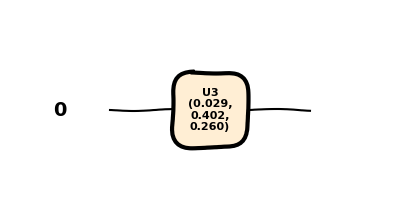

In [17]:
fig, ax = qml.draw_mpl(GeneratorVF, style="sketch", decimals=3)(weights_gen)
fig.show()

/var/folders/__/yb0d9fls4r9gb8t6yccwhq_w0000gn/T/ipykernel_72331/680881361.py:2: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


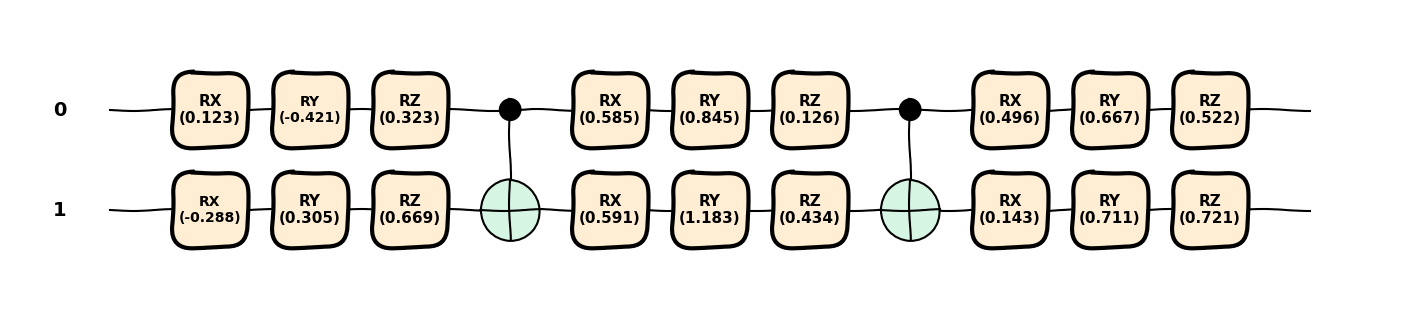

In [33]:
fig, ax = qml.draw_mpl(DiscriminatorVF, style="sketch", decimals=3)(2, weights_dis, reps = 2)
fig.show()

In [6]:
state_0 = [[1], [0]]
M = state_0 * np.conj(state_0).T

In [7]:
dev = qml.device('default.qubit', wires = 2)

@qml.qnode(dev, interface="torch", diff_method = "backprop")
def true_discriminator(weights_dis):
    PrepareTrueState()
    Discriminator(weights_dis)
    return qml.expval(qml.Hermitian(M, wires = [0]))


@qml.qnode(dev, interface="torch", diff_method = "backprop")
def generator_discriminator(weights_gen, weights_dis):
    Generator(weights_gen)
    Discriminator(weights_dis)
    return qml.expval(qml.Hermitian(M, wires = [0]))

In [8]:
def discriminator_loss(weights_gen, weights_dis):
    
    # Outcome of the discriminator with a generated state.
    out_gen = generator_discriminator(weights_gen, weights_dis)

    # Outcome of the discriminator with the true state.
    out_true = true_discriminator(weights_dis)

    return -(torch.log(1 - out_gen) + torch.log(out_true))/2

In [9]:
def generator_loss(weights_gen, weights_dis):
    out_gen = generator_discriminator(weights_gen, weights_dis)
    return -torch.log(out_gen)

In [10]:
weights_gen = torch.rand(3, requires_grad = True)
weights_dis = torch.rand((3 + 1) * 2 * 3, requires_grad = True)

In [11]:
optg = torch.optim.SGD([weights_gen], lr = 0.5)
optd = torch.optim.SGD([weights_dis], lr = 0.5)

In [18]:
dis_losses = [] # Discriminator losses.
gen_losses = [] # Generator losses.
log_weights = [] # Generator weights.

ncycles = 150 # Number of training cycles.

for i in range(ncycles):
    # Train the discriminator.
    optd.zero_grad()
    lossd = discriminator_loss(weights_gen.detach(), weights_dis)
    lossd.backward()
    optd.step()
    
    # Train the generator.
    optg.zero_grad()
    lossg = generator_loss(weights_gen, weights_dis.detach())
    lossg.backward()
    optg.step()
    
    # Log losses and weights.
    lossd = float(lossd)
    lossg = float(lossg)
    dis_losses.append(lossd)
    gen_losses.append(lossg)
    log_weights.append(weights_gen.detach().clone().numpy())
    
    # Print the losses every fifteen cycles.
    if (np.mod((i+1), 15) == 0):
        print("Epoch", i+1, end= " ")
        print("| Discriminator loss:", round(lossd, 4), end = " ")
        print("| Generator loss:", round(lossg, 4))

Epoch 15 | Discriminator loss: 0.6701 | Generator loss: 0.7065
Epoch 30 | Discriminator loss: 0.6987 | Generator loss: 0.6791
Epoch 45 | Discriminator loss: 0.6931 | Generator loss: 0.6992
Epoch 60 | Discriminator loss: 0.6931 | Generator loss: 0.6924
Epoch 75 | Discriminator loss: 0.6932 | Generator loss: 0.6927
Epoch 90 | Discriminator loss: 0.6931 | Generator loss: 0.6934
Epoch 105 | Discriminator loss: 0.6931 | Generator loss: 0.6931
Epoch 120 | Discriminator loss: 0.6931 | Generator loss: 0.6931
Epoch 135 | Discriminator loss: 0.6931 | Generator loss: 0.6932
Epoch 150 | Discriminator loss: 0.6931 | Generator loss: 0.6931


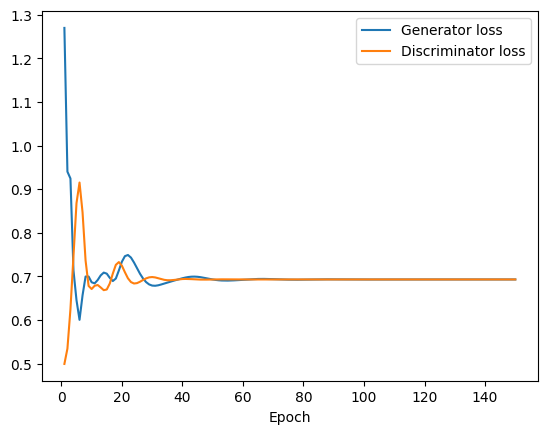

In [19]:
import matplotlib.pyplot as plt
epochs = np.array(range(len(gen_losses))) + 1
plt.plot(epochs, gen_losses, label = "Generator loss")
plt.plot(epochs, dis_losses, label = "Discriminator loss")
plt.xlabel("Epoch")
plt.legend()

In [20]:
@qml.qnode(dev, interface="torch")
def generated_coordinates(weights_gen):
    Generator(weights_gen)
    return [qml.expval(qml.PauliX(0)), qml.expval(qml.PauliY(0)),
    qml.expval(qml.PauliZ(0))]

@qml.qnode(dev, interface="torch")
def true_coordinates():
    PrepareTrueState()
    return [qml.expval(qml.PauliX(0)), 
            qml.expval(qml.PauliY(0)),
            qml.expval(qml.PauliZ(0))]

print("Bloch coordinates")
print("Generated:", generated_coordinates(weights_gen))
print("True:", true_coordinates())

Bloch coordinates
Generated: [tensor(0.3535, dtype=torch.float64, grad_fn=<DotBackward0>), tensor(0.6124, dtype=torch.float64, grad_fn=<DotBackward0>), tensor(0.7071, dtype=torch.float64, grad_fn=<DotBackward0>)]
True: [tensor(0.3536, dtype=torch.float64), tensor(0.6124, dtype=torch.float64), tensor(0.7071, dtype=torch.float64)]


In [21]:
true_coords = true_coordinates()
def plot_coordinates(cycle):

    coords = generated_coordinates(log_weights[cycle - 1])

    plt.bar(["X", "Y", "Z"], true_coords, width = 1,
        color = "royalblue", label = "True coordinates")
    plt.bar(["X", "Y", "Z"], coords, width = 0.5,
        color = "black", label = "Generated coordinates")

    plt.title(f"Training cycle {cycle}")
    plt.legend()

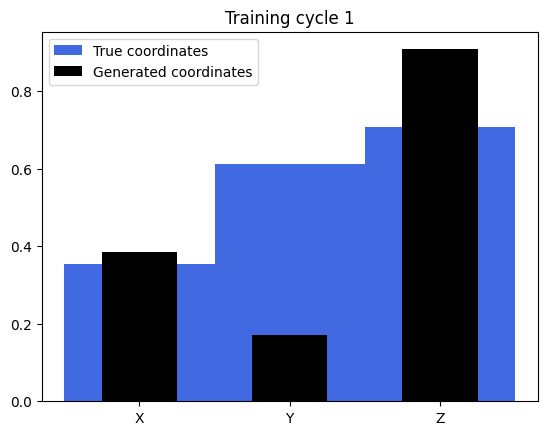

In [29]:
plot_coordinates(1)

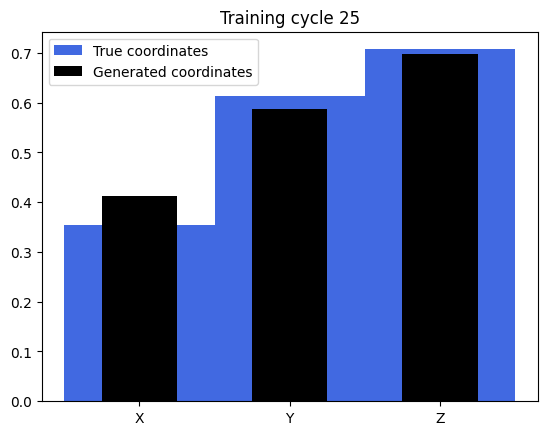

In [30]:
plot_coordinates(25)

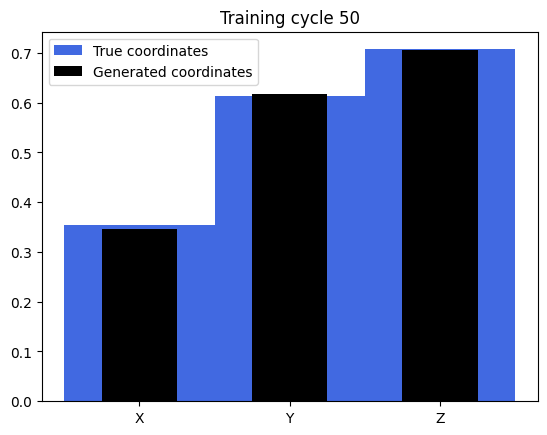

In [31]:
plot_coordinates(50)

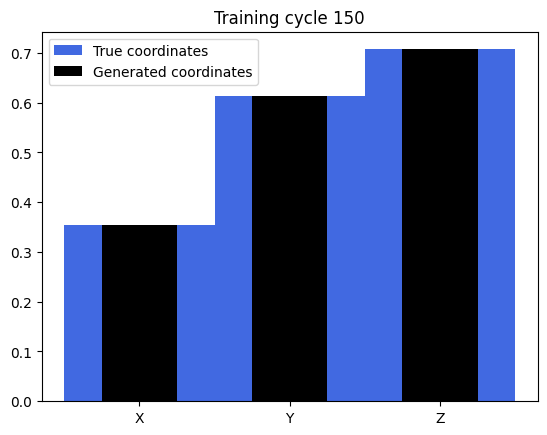

In [32]:
plot_coordinates(150)